# Predicting Uber Fare Prices
## Mark Bowen & John Ruscito & Peyton Theil

## Imports and Dependency Installation

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
import datetime
import geopandas as gpd
from shapely.geometry import Point, Polygon
import gradio as gr
from google.colab import files

## Data

### Import data and Inspect the Data

In [4]:
uber_data = pd.read_csv('https://raw.githubusercontent.com/m-bowen/Uber_Regression/main/uber.csv')
print("Shape of the Data: ", uber_data.shape)
uber_data.head(10)

Shape of the Data:  (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
5,44470845,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1
6,48725865,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5
7,44195482,2012-12-11 13:52:00.00000029,2.5,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1
8,15822268,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1
9,50611056,2012-03-29 19:06:00.000000273,12.5,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,40.775012,1


In [5]:
print("Check for null values:\n", uber_data.isnull().sum())
uber_data = uber_data.dropna()
print("Null values after dropping:\n", uber_data.isnull().sum())


Check for null values:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64
Null values after dropping:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


### Feature Engineer pickup_datetime

In [6]:
uber_data.pickup_datetime = pd.to_datetime(uber_data.pickup_datetime, format = '%Y-%m-%d %H:%M:%S UTC', errors='coerce')

In [7]:
uber_data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5


In [8]:
(uber_data.pickup_datetime == "NaT").sum()

0

Extract extra information from pickup_datetime. <br>
Year is not important since it will never repeat (i.e. it will never be 2019 again)

In [9]:
uber_data['pickup_month'] = uber_data.pickup_datetime.dt.month
uber_data['pickup_week'] = uber_data.pickup_datetime.dt.isocalendar().week
uber_data['pickup_day'] = uber_data.pickup_datetime.dt.day
uber_data['pickup_hour'] = uber_data.pickup_datetime.dt.hour
uber_data['pickup_minute'] = uber_data.pickup_datetime.dt.minute
uber_data['pickup_dayofweek'] = uber_data.pickup_datetime.dt.dayofweek
uber_data[['pickup_month', 'pickup_week', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek']].head()

,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,5,19,7,19,52,3
1,7,29,17,20,4,4
2,8,35,24,21,45,0
3,6,26,26,8,22,4
4,8,35,28,17,47,3


Now that we have extracted the useful information out of pickup_datetime, we can remove the column from the data

Let's also drop key and id since they are not necessary for learning

In [10]:
uber_data = uber_data.drop(columns = ['pickup_datetime', 'key', 'Unnamed: 0'])
uber_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_month,pickup_week,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,5,19,7,19,52,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,7,29,17,20,4,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,8,35,24,21,45,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,6,26,26,8,22,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,8,35,28,17,47,3


In [11]:
uber_data.dtypes 

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
pickup_month           int64
pickup_week           UInt32
pickup_day             int64
pickup_hour            int64
pickup_minute          int64
pickup_dayofweek       int64
dtype: object

### Let's take a look at the latitude and longitude now

*Files could not be uploaded to Github due to size, but can be accessed here*: 
- [world_countries_2020](https://international.ipums.org/international/gis.shtml)
- [nyc_street](https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b)

*In addition, both .shp and .shx files **must** be uploaded.* 

*If you do not want to render visualizations of coordinates, you can comment out cells 12, 14, & 16*

In [12]:
uploaded = files.upload()

Saving world_countries_2020.shp to world_countries_2020 (1).shp
Saving nyc_streets.shp to nyc_streets (1).shp
Saving nyc_streets.shx to nyc_streets (1).shx
Saving world_countries_2020.shx to world_countries_2020 (1).shx


In [13]:
# Function that makes plotting multiple times easier 
def plot_coords(map_file, dataframe):


  # Set coordinate system
  coord_ref_sys = {'init': 'epsg:4326'}

  # Create Coordinates
  pickup_coords = [Point(xy) for xy in zip(dataframe.pickup_longitude, dataframe.pickup_latitude)]
  dropoff_coords = [Point(xy) for xy in zip(dataframe.dropoff_longitude, dataframe.dropoff_latitude)]

  # Created special dataframes
  pickup_df = gpd.GeoDataFrame(dataframe, crs = coord_ref_sys, geometry = pickup_coords)
  dropoff_df = gpd.GeoDataFrame(dataframe, crs = coord_ref_sys, geometry = dropoff_coords)

  # Actual Plotting
  map = gpd.read_file(map_file)
  fig, ax = plt.subplots(figsize = (15,15))
  
  pickup_df.plot(ax = ax, markersize = 5, color = "blue", marker = '^', label = "Pickup")
  dropoff_df.plot(ax = ax, markersize = 1, color = "red", marker = 'v', label = "Dropoff")
  map.plot(ax = ax, alpha = .4, color="grey")
  plt.legend(prop={'size': 15})


/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


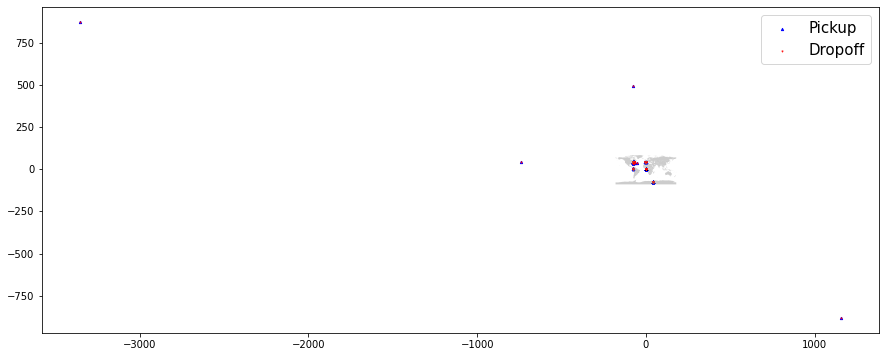

In [14]:
plot_coords(map_file = 'world_countries_2020.shx', dataframe = uber_data)

### As you can see from the figure above, there are many errors such as latitude and longitudes that do not exist and are in different parts of the world.

Our team is only interested in Ubers in New York City. Let's make sure latitude and longitude are all NYC based. (40 <= Lat <= 41 and -75 <= Long <= -73)

In [15]:
uber_data = uber_data[uber_data.pickup_latitude <= 40.9]
uber_data = uber_data[uber_data.pickup_latitude >= 40.5]
uber_data = uber_data[uber_data.pickup_longitude <= -73.7]
uber_data = uber_data[uber_data.pickup_longitude >= -74.2]
uber_data = uber_data[uber_data.dropoff_latitude <= 40.9]
uber_data = uber_data[uber_data.dropoff_latitude >= 40.5]
uber_data = uber_data[uber_data.dropoff_longitude <= -73.7]
uber_data = uber_data[uber_data.dropoff_longitude >= -74.2]

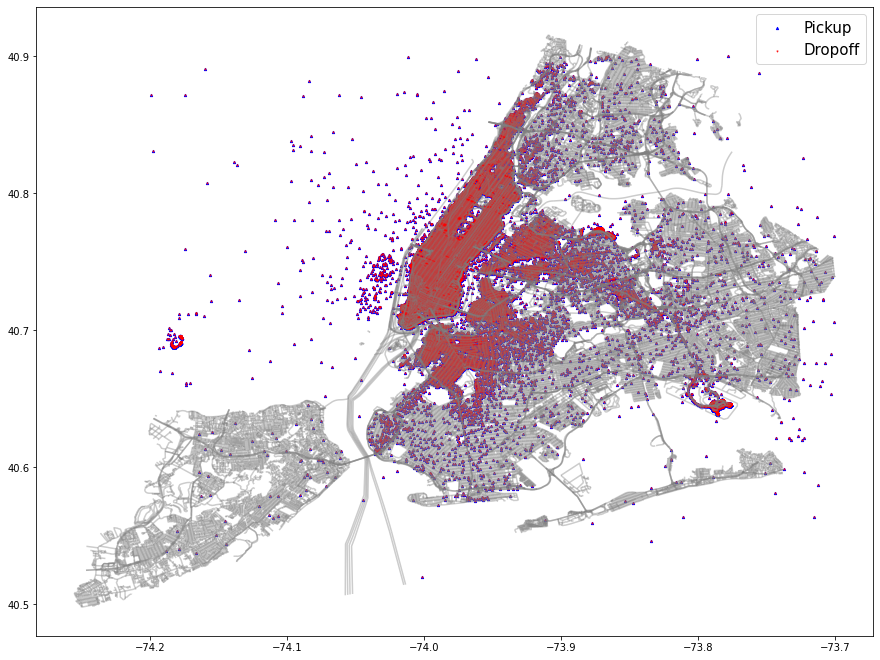

In [16]:
plot_coords('nyc_streets.shp', uber_data)

Now we can see that all the longitude and latitudes are in New York City and the surronding area.

Inspect Target Variable

Max fare: 499.0 || Min Fare: -52.0
Percentiles of fare: [ 3.7   6.    8.5  12.5  42.33]


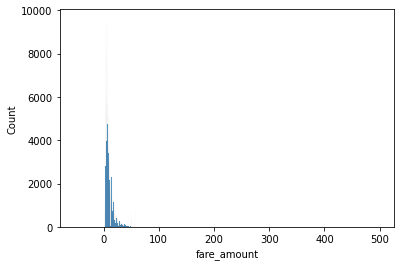

In [17]:
print("Max fare: {} || Min Fare: {}".format(max(uber_data.fare_amount), min(uber_data.fare_amount)))
print("Percentiles of fare: {}".format(np.percentile(uber_data.fare_amount, q = [2.5, 25, 50, 75, 97.5])))
sns.histplot(uber_data.fare_amount)

From looking at the min, max, and histogram together, we can see that there are outliers. We should drop all rows that have fare_amount under 0 because this is unrealistic. We should also drop values that are above the 95 percentile.

In [18]:
uber_data = uber_data[uber_data.fare_amount > 0]
uber_data = uber_data[uber_data.fare_amount <= np.percentile(uber_data.fare_amount, q = 95)]

# check percentiles to make sure correct drops were performed
print("Min Fare: {} || Max Fare: {}".format(min(uber_data.fare_amount), max(uber_data.fare_amount)))

Min Fare: 0.01 || Max Fare: 30.0


Now let's take another look at the histogram of fare_amount to get an idea of the distribution

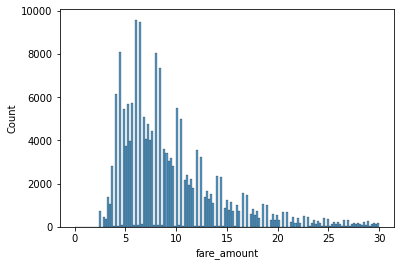

In [19]:
sns.histplot(uber_data.fare_amount)

### Create X (all features) and Y (fare_amount)

In [20]:
Y = uber_data.fare_amount
X = uber_data.drop(columns=['fare_amount', 'geometry'])
print("X shape: {} \nY shape: {}".format(X.shape, Y.shape))

X shape: (185717, 11) 
Y shape: (185717,)


### Split Data into Training sets and Testing sets

In [21]:
Xtr, Xte, Ytr, Yte = ms.train_test_split(X, Y) # shuffle is true by default & test_size is .25 by default
print("Xtr shape: {} \nXte shape: {} \nYtr shape: {}\nYte shape: {}".format(Xtr.shape, Xte.shape, Ytr.shape, Yte.shape))

Xtr shape: (139287, 11) 
Xte shape: (46430, 11) 
Ytr shape: (139287,)
Yte shape: (46430,)


## Search for the best preprocessing techniques

### Here we implement our own grid search that is quite computationally expensive but allows us to try more complex combinations than sklearn's implementation

In [22]:
model_grid = {
    "Ridge Alpha = .1 ": lm.Ridge(alpha = .1),
    "Ridge Alpha = .01 ": lm.Ridge(alpha = .01),
    "Ridge Alpha = .001 ": lm.Ridge(alpha = .001)
    }
scaler_grid = {
    'MinMax': pp.MinMaxScaler(), 
    'Robust': pp.RobustScaler(), 
    'Standard': pp.StandardScaler()
    }
transformer_grid = {
    'Quantile': pp.QuantileTransformer(),
    # 'Power': pp.PowerTransformer() // We dont apply this anymore since all tests before gave negative results and it slows runtime down drastically
    }
poly_feats_grid = {
    "pf = 1": pp.PolynomialFeatures(degree = 1),
    "pf = 2": pp.PolynomialFeatures(degree = 2),
    "pf = 3": pp.PolynomialFeatures(degree = 3),
    "pf = 4": pp.PolynomialFeatures(degree = 4)
    }

In [23]:
# Create Dictionary to track scores
scores = {}

# Compute base model (Normal Linear Regression since alpha = 0)
base_model = lm.Ridge()
base_model.fit(Xtr, Ytr)
base_y_preds = base_model.predict(Xte)
error = mean_squared_error(base_y_preds, Yte, squared = False)
print("No Transformations: {}".format(error))
scores["No Transformations"] = error
best_score = error
best_model_name = "base_model"
best_model = None
best_scaler_name = "None"
best_scaler = None
best_transformer_name = "None"
best_transformer = None


# Set up nested for loops (This is what makes it so computationally expensive)
for h, (model_name, model) in enumerate(model_grid.items()):
    for i, (scaler_name, scaler) in enumerate(scaler_grid.items()):
        for j, (transformer_name, transformer) in enumerate(transformer_grid.items()):
            for k, (pf_degree, poly_feats) in enumerate(poly_feats_grid.items()):

                # Create the pipeline with all the different possible preprocessing combinations
                pipe = pipeline.make_pipeline(scaler, transformer, poly_feats, model)
                
                # Cross validate the combination (Also what makes it compuationally expensive)
                cv_scores = ms.cross_validate(pipe.fit(Xtr, Ytr), Xtr, Ytr, scoring='neg_root_mean_squared_error')

                # Create combination string to be used as a key in dictionary storing scores
                combination = model_name + ", " + scaler_name + ", " + transformer_name + ", " + pf_degree

                # Calcuate average score of folds
                score = -1 * (sum(cv_scores['test_score']) / len(cv_scores['test_score']))

                # Store score in dictionary
                scores[combination] = score

                # If the score is lower than the previous best: Keep track of parameters
                if score < best_score: 
                    best_score = score
                    best_model_name = model_name
                    best_model = model
                    best_scaler_name = scaler_name
                    best_scaler = scaler
                    best_transformer_name = transformer_name
                    best_transformer = transformer
                    best_pf_degree = pf_degree
                    best_pf = poly_feats
                    best_pipe = pipe
                    best_cv_stats = cv_scores
                    print("\nNew Best: {}, {}, {}, {}\nScore: {}".format(model_name, scaler_name, transformer_name, pf_degree, score))

print("\nBest Combination:\nBest Alpha: {}\nBest Scaler: {}\nBest Transformer: {}\nBest PolyFeat Degree: {}\nBest Score: {}".format(best_model_name, best_scaler_name, best_transformer_name, best_pf_degree, best_score))


No Transformations: 4.948577783378931

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 2
Score: 3.5775510579039773

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 3
Score: 3.4694738749172784

New Best: Ridge Alpha = .1 , MinMax, Quantile, pf = 4
Score: 3.0400757305728114

New Best: Ridge Alpha = .1 , Robust, Quantile, pf = 4
Score: 3.039473456941302

New Best: Ridge Alpha = .01 , MinMax, Quantile, pf = 4
Score: 3.003284373540713

New Best: Ridge Alpha = .01 , Robust, Quantile, pf = 4
Score: 3.00317923293001

Best Combination:
Best Alpha: Ridge Alpha = .01 
Best Scaler: Robust
Best Transformer: Quantile
Best PolyFeat Degree: pf = 4
Best Score: 3.00317923293001


## Best Combination of preprocessing techniques

In [24]:
best_pipe.named_steps

{'robustscaler': RobustScaler(),
 'quantiletransformer': QuantileTransformer(),
 'polynomialfeatures': PolynomialFeatures(degree=4),
 'ridge': Ridge(alpha=0.01)}

## Time to put the best model up against the Test Set

In [25]:
best_pipe.fit(Xtr, Ytr)
y_preds = best_pipe.predict(Xte)
rmse = mean_squared_error(Yte, y_preds, squared = False)
print("Test Error: {}".format(rmse))

Test Error: 3.0126867396452597


## Plot 50 Predictions against Actual Values

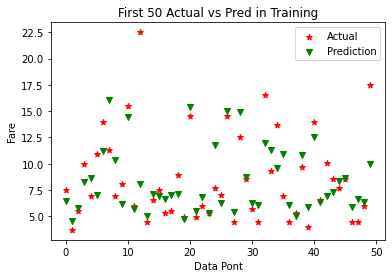

In [26]:
plt.title("First 50 Actual vs Pred in Training")
plt.ylabel("Fare")
plt.xlabel("Data Pont")
plt.scatter(np.arange(0, 50), Yte[:50], color='r', label = "Actual", marker = '*')
plt.scatter(np.arange(0, 50), y_preds[:50], color = 'g', label = "Prediction", marker = 'v')
plt.legend()

# Deploy Model

In [27]:
Xte.shape

(46430, 11)

Train has 11 features, so our requests has needs to be a 1,11

 ## Get min and max long and lat so user can not enter out of bounds data (NYC)

In [28]:
max_pickup_lat = max(uber_data.pickup_latitude)
max_dropoff_lat = max(uber_data.dropoff_latitude)

max_lat = max(max_pickup_lat,max_dropoff_lat)

In [29]:
max_pickup_lon = max(uber_data.pickup_longitude)
max_dropoff_lon = max(uber_data.dropoff_longitude)

max_lon = max(max_pickup_lon,max_dropoff_lon)

In [30]:
min_pickup_lat = min(uber_data.pickup_latitude)
min_dropoff_lat = min(uber_data.dropoff_latitude)

min_lat = min(min_pickup_lat,min_dropoff_lat)

In [31]:
min_pickup_lon = min(uber_data.pickup_longitude)
min_dropoff_lon= min(uber_data.dropoff_longitude)

min_lon = min(min_pickup_lon,min_dropoff_lon)

In [32]:
print("Max Lon: {} \n Max Lat: {} \n Min Lon: {} \n Min Lat: {}".format(max_lon,max_lat,min_lon,min_lat))

Max Lon: -73.70065 
 Max Lat: 40.899093 
 Min Lon: -74.197643 
 Min Lat: 40.510902


## Encode months

In [33]:
month_dictionary = { 
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}

## Create prediction model 

In [34]:
def change_month_to_int(month):
  return month_dictionary[month]

In [35]:
def predict_uber_price(plon,plat,dlon,dlat,passengers,month,day,hour,minute):

  # Turn string month into int for data
  month = change_month_to_int(month)

  # Get which day of the week the user requested
  requested_date = datetime.date(2022,month,day)
  day_of_week = datetime.datetime.weekday(requested_date) 

  # Get what week of the year this date is
  week_of_year = datetime.date(2022, month, day).isocalendar()[1]

  user_input = np.array([plon,plat,dlon,dlat,passengers,month,week_of_year,day,hour,minute,day_of_week])
  user_input = user_input.reshape(1,-1)

  pred = best_pipe.predict(user_input)

  return '${0:.2f}'.format(pred[0])


## Define inputs

In [36]:
# Coords
plon = gr.inputs.Slider(minimum=min_lon,maximum=max_lon, label= "Pickup Longitude")
plat = gr.inputs.Slider(minimum=min_lat,maximum=max_lat, label= "Pickup Latitude")
dlon = gr.inputs.Slider(minimum=min_lon,maximum=max_lon, label= "Dropoff Longitude")
dlat = gr.inputs.Slider(minimum=min_lat,maximum=max_lat, label= "Dropoff Latitude")

# Date
month= gr.inputs.Dropdown(choices=["January", "February", "March", "April",
                                   "May", "June", "July", "August", "September",
                                   "October", "November", "December"], label= "Month")
day= gr.inputs.Slider(minimum=1,maximum=31, label= "Day", step=1)


# Time
hour = gr.inputs.Slider(minimum=1, maximum=24, label="Pickup Hour", step=1)
minute = gr.inputs.Slider(minimum=0, maximum=60, label="Pickup Minute", step=1)

# Passengers
passengers = gr.inputs.Slider(minimum=1,maximum=10, label= "Number of Passengers", step=1)

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:88: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:216: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(


## Launch app

In [37]:
output = gr.outputs.Textbox(label = "Predicted Uber Price")

demo = gr.Interface(fn=predict_uber_price,
                    inputs=[plon, plat, dlon, dlat, passengers,month,day,hour,minute], 
                    outputs=[output]
)

demo.launch(share = True)

/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:21: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.
Running on public URL: https://a1f612d5-d300-4166.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
